# HW3: Netflix Data Analysis

In this homework assignment, you will analyze the netflix prize data. The data consist of 100,480,50 movie ratings on a scale from 0 to 5 stars. The reviews are distributed across 17,770 movies and 480,189. We have provided the training data as a sparse matrix where the row corresponds to the movie ID and the column corresponds to the user ID. A seperate file contains the title and year of release for each movie. The original, raw data consists of multiple lists of tuples; each list is a seperate movie and each tuple is User ID, Rating, and Rating Year. 
The original data can be downloaded here: https://archive.org/download/nf_prize_dataset.tar
Further information about the netflix prize is available online: 
https://en.wikipedia.org/wiki/Netflix_Prize
https://www.netflixprize.com/

In [2]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import scipy.sparse
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, MiniBatchKMeans


In [3]:
# This file consists of titles and release years associated with each ID
movie_titles = pd.read_csv('movie_titles.txt', header = None, names = ['ID','Year','Name'], encoding="latin-1")
print(movie_titles.head())
print(movie_titles.shape)

   ID    Year                          Name
0   1  2003.0               Dinosaur Planet
1   2  2004.0    Isle of Man TT 2004 Review
2   3  1997.0                     Character
3   4  1994.0  Paula Abdul's Get Up & Dance
4   5  2004.0      The Rise and Fall of ECW
(17770, 3)


In [4]:
# This file is a sparse matrix of movies by user, with each element a rating (1-5) or nonresponse (0)
ratings_csr = scipy.sparse.load_npz('netflix_full_csr.npz')
print(ratings_csr.shape)

(17771, 2649430)


To avoid memory overflow errors we have randomly subsampled the data. Some computers can handle the full dataset (e.g. 2017 Macbook Pro can perform SVD on the full dataset). Older computers likely need to subsample the data. You can consider using Princeton computing resources and clusters to perform more computationally expensive analysis.

In [15]:
#n_samples = 5000
n_viewers = 10000
#random_sample_movies = np.random.choice(17771, size = n_samples)
random_sample_viewers = np.random.choice(2649430, size = n_viewers)
ratings_small = ratings_csr[:,random_sample_viewers]
print(ratings_small.shape)

(17771, 10000)


We will perform some exploratory data analysis to get a sense for how the distribution of reviews and general views looks for across both users and movies.


In [49]:
import matplotlib.pyplot as plt

movie_1 = []
movie_2 = []
movie_3 = []
movie_4 = []
movie_5 = []


for i in range(0, ratings_small.shape[0]):
    reviews = ratings_small[i,:].toarray()[0]
    unique, counts = np.unique(reviews, return_counts=True)
    if np.any(unique == 1):
        movie_1.append(counts[np.where(unique ==1)][0])
    else:
        movie_1.append(0)
    if np.any(unique == 2):
        movie_2.append(counts[np.where(unique ==2)][0])
    else:
        movie_2.append(0)
    if np.any(unique == 3):
        movie_3.append(counts[np.where(unique ==3)][0])
    else:
        movie_3.append(0)
    if np.any(unique == 4):
        movie_4.append(counts[np.where(unique ==4)][0])
    else:
        movie_4.append(0)
    if np.any(unique == 5):
        movie_5.append(counts[np.where(unique ==5)][0]) 
    else:
        movie_5.append(0)
        
movie_1 = np.array(movie_1)
movie_2 = np.array(movie_2)
movie_3 = np.array(movie_3)
movie_4 = np.array(movie_4)
movie_5 = np.array(movie_5)
total_reviews = movie_1 +  movie_2 + movie_3 + movie_4 + movie_5

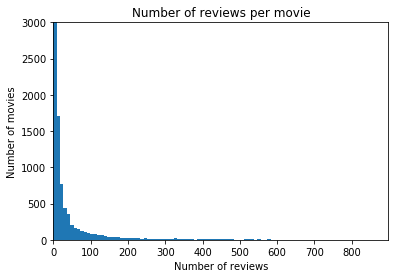

In [76]:
plt.hist(total_reviews, bins=100)  # arguments are passed to np.histogram
plt.title("Number of reviews per movie")
plt.ylabel("Number of movies")
plt.xlabel("Number of reviews")
plt.xlim(0, np.max(movie_reviews)+1)
plt.ylim(0, 3000)
plt.show()

/Users/Cat/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[ 0.          0.          0.         ...,  2.33333333  2.74193548  3.5       ]


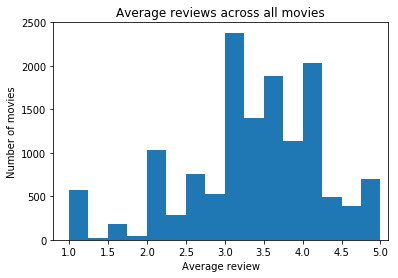

In [77]:
review_sum = movie_1 +  (2*movie_2) + (3*movie_3) + (4*movie_4) + (5* movie_5)
avg_review = review_sum / total_reviews
avg_review = np.nan_to_num(avg_review)
print(avg_review)
plt.hist(avg_review, bins=20)  # arguments are passed to np.histogram
plt.title("Average reviews across all movies")
plt.ylabel("Number of movies")
plt.xlabel("Average review")
plt.xlim(.8, 5.1)
plt.ylim(0, 2500)
plt.show()

A common methods for analyzing large datasets is dimension reduction. Here we perform a truncated SVD suited for sparse datasets and analyze which movies are associated with different latent dimensions

In [78]:
from sklearn.decomposition import TruncatedSVD

In [79]:
n_components = 5
svd = TruncatedSVD(n_components = n_components)

In [80]:
Z = svd.fit_transform(ratings_small)

In [81]:
components = svd.components_

In [82]:
print(svd.explained_variance_ratio_)

[ 0.22944731  0.02826338  0.02358565  0.01780093  0.01493732]


In [83]:
for i in range(0,n_components):
    Z_sort = np.argsort(np.abs(Z[:,i]))
    print('Component ' + str(i))
    for j in range(1,10):
        movie_index = Z_sort[-j]
        movie_title = movie_titles[movie_titles['ID'] == movie_index]['Name']
        movie_weight = Z[movie_index,i]
        print(str(movie_title) + ': ' + str(movie_weight))
    print(' ')

Component 0
1904    Pirates of the Caribbean: The Curse of the Bla...
Name: Name, dtype: object: 90.7425
11282    Forrest Gump
Name: Name, dtype: object: 89.8453
2451    Lord of the Rings: The Fellowship of the Ring
Name: Name, dtype: object: 82.144
11520    Lord of the Rings: The Two Towers
Name: Name, dtype: object: 82.0882
4305    The Sixth Sense
Name: Name, dtype: object: 81.6371
16376    The Green Mile
Name: Name, dtype: object: 81.053
14549    The Shawshank Redemption: Special Edition
Name: Name, dtype: object: 80.8419
14690    The Matrix
Name: Name, dtype: object: 77.748
15123    Independence Day
Name: Name, dtype: object: 77.2635
 
Component 1
4995    Gone in 60 Seconds
Name: Name, dtype: object: 32.976
5316    Miss Congeniality
Name: Name, dtype: object: 32.068
15204    The Day After Tomorrow
Name: Name, dtype: object: 30.3339
6971    Armageddon
Name: Name, dtype: object: 30.2564
12671    John Q
Name: Name, dtype: object: 29.3686
9339    Pearl Harbor
Name: Name, dtype: object:

In [84]:
svd.explained_variance_

array([ 70.90826416,   8.73449802,   7.28889751,   5.50119019,   4.61622143], dtype=float32)